# Sentiment Analysis comments

<b>Задача:</b> Необходимо построить модель для классификации комментариев на позитивные и негативные. 

In [229]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm, trange

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from transformers import (BertForSequenceClassification, BertTokenizer, Trainer, 
                          TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, 
                          get_linear_schedule_with_warmup)

import torch
from torch.utils.data import Dataset

import evaluate
import pickle

## Text preprocessing

In [2]:
tqdm.pandas()

In [261]:
df_train = pd.read_csv('datasets/toxic_comments_train.csv')
display(df_train.info())
display(df_train.head())

df_valid = pd.read_csv('datasets/toxic_comments_valid.csv')
display(df_valid.info())
display(df_valid.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15000 non-null  object
 1   toxic   15000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.5+ KB


None

,text,toxic
0,"Thanks for the help on the young buck mixtape,...",0
1,User Communicat (mediation request not accep...,0
2,"""\n\n Zora and Aiden, You, being Non-Muslims, ...",0
3,I would be very glad to discuss in detail your...,0
4,It's easier to discuss when everything looks n...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   toxic   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


None

,text,toxic
0,I'll fuck you forever!,1
1,I dont care about kurds actually (i am neutral...,1
2,Louis Proyect is closer to my politics than an...,1
3,"FUCK YOU, YOU RACIST ASSHOLE",1
4,Someone is threatning an annon and that is unc...,1


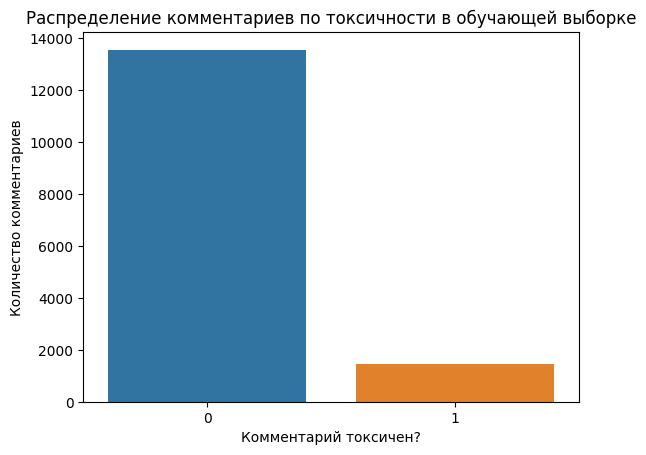

In [5]:
sns.countplot(x="toxic", data=df_train)
plt.title('Распределение комментариев по токсичности в обучающей выборке')
plt.ylabel('Количество комментариев')
plt.xlabel('Комментарий токсичен?')
plt.show()

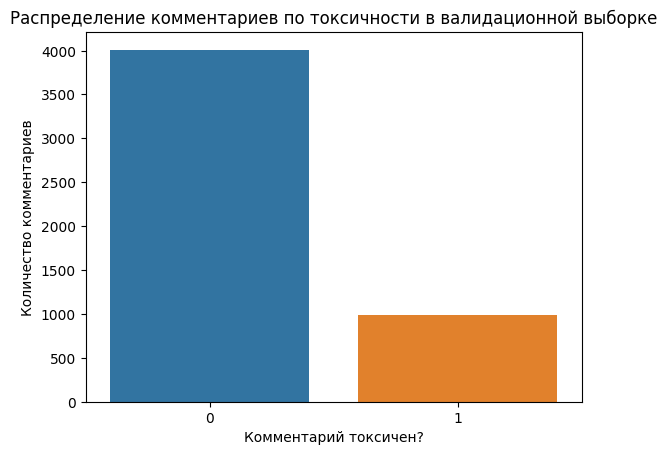

In [6]:
sns.countplot(x="toxic", data=df_valid)
plt.title('Распределение комментариев по токсичности в валидационной выборке')
plt.ylabel('Количество комментариев')
plt.xlabel('Комментарий токсичен?')
plt.show()

В выборках присутствует дисбаланс классов. Негативных комментариев в обучающей выборке в 9 раз меньше ,чем позитивных.

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vmaslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vmaslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/vmaslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = nltk.word_tokenize(text)
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [9]:
df_train['clear_text'] = df_train['text'].progress_apply(lambda x: preprocess_text(x))
df_valid['clear_text'] = df_valid['text'].progress_apply(lambda x: preprocess_text(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2951.91it/s]


Была проведена предобработка текста (текст привели к нижнему регистру, удалили спец символы и цифры, удалили стоп-слова, провели лемматизацию)

## Training

### Классификация текстов с помощью TFIDF и LogReg

In [244]:
corpus_train = df_train['clear_text'].values.astype('U')
tfidf_vectorizer= TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(corpus_train)
y_train = df_train['toxic']


corpus_valid = df_valid['clear_text'].values.astype('U')
X_valid = tfidf_vectorizer.transform(corpus_valid)
y_valid = df_valid['toxic']

Получены значения TF-IDF для тестовой и обучающей выборки.

In [245]:
model_lr = LogisticRegression(class_weight='balanced', random_state=123456, solver='liblinear',)

In [246]:
lr_param_grid = {
            'penalty' : ['l1', 'l2'],
            'C': np.logspace(-10,10,20)
        }


# Прогоняем модель через GridSearchCV для нахождения лучших параметров.
grid = GridSearchCV(model_lr,  param_grid=lr_param_grid, scoring='f1', cv=3, verbose=True)
grid.fit(X_train, y_train)
print('Best params: ', grid.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params:  {'C': 3.359818286283774, 'penalty': 'l1'}


Подобраны параметры кросс-валидацией для модели Логистической регресии.

In [247]:
model_lr = LogisticRegression(class_weight='balanced', random_state=123456, solver='liblinear', C=3.35, penalty='l1')
model_lr.fit(X_train, y_train)
pred = pd.Series(model_lr.predict(X_valid))
F1= f1_score(y_valid, pred)
print('F1-мера для Логистической регрессии {:.1%}'.format(F1))

F1-мера для Логистической регрессии 78.9%


In [248]:
model_data = {
    'model': model_lr,
    "tfidf_vectorizer": tfidf_vectorizer, 
    }

In [249]:
pickle.dump(model_data, open('models/model_lr/model.pkl', 'wb'))

### Классификация текстов с помощью BERT

In [22]:
DEVICE = 'cuda:0'
EPOCH_NUM = 1
BATCH_SIZE = 20
WARMUP_STEPS = 100
EARLY_STOPPING_PATIENCE = 5

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer,labels, max_length=128):
        self.tokenizer = tokenizer        
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, _idx):
        text=self.texts[_idx]
        tokens = self.tokenizer(text, max_length=self.max_length, padding=False, truncation=True, return_tensors="pt", 
                                return_attention_mask=False, return_token_type_ids=False)

        x = tokens["input_ids"][0]
        res = {
            "input_ids": x,
            "token_type_ids": torch.zeros_like(x), 
            "attention_mask": torch.ones_like(x), 
        }
        res['labels'] = self.labels[_idx]
        return res


In [17]:
train_dataset = CustomDataset(corpus_train, tokenizer, df_train['toxic'].values)
valid_dataset = CustomDataset(corpus_valid, tokenizer, df_valid['toxic'].values)

In [129]:
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=WARMUP_STEPS, num_training_steps=int(EPOCH_NUM * len(train_dataset) / BATCH_SIZE)
    )

In [26]:
metric = evaluate.load('f1')

def compute_metrics(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)
	return metric.compute(predictions=predictions, references=labels)

In [27]:
training_args = TrainingArguments(
    load_best_model_at_end = True,
    output_dir='models/model_bert',  # Директория для сохранения результатов
    num_train_epochs=EPOCH_NUM,  # Количество эпох
    per_device_train_batch_size=BATCH_SIZE,  # Размер батча
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy='steps',
    save_steps=150,  # Сохранять модель каждые 10 шагов
    eval_steps=150,
    logging_dir='logs',  # Директория для логов
    save_total_limit=1,
    fp16=True
)


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer, padding="longest"),
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler),
    compute_metrics = compute_metrics
)
trainer.train()

Step,Training Loss,Validation Loss,F1
150,No log,0.411276,0.531664
300,No log,0.281969,0.743669
450,No log,0.200017,0.816327
600,0.198700,0.198777,0.833060
750,0.198700,0.177129,0.833698


TrainOutput(global_step=750, training_loss=0.1733957824707031, metrics={'train_runtime': 2881.5137, 'train_samples_per_second': 5.206, 'train_steps_per_second': 0.26, 'total_flos': 934033968752400.0, 'train_loss': 0.1733957824707031, 'epoch': 1.0})

F1-мера для Bert 83.4%

## Testing models

### Load test dataset

In [250]:
df_test = pd.read_csv('datasets/toxic_comments_test.csv')
display(df_test.info())
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   toxic   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


None

,text,toxic
0,Regional Versions \n\nWhen my friends from Eng...,0
1,"you really don't get it do you, it not one or ...",0
2,"WP:VG assessment\nWell, this is definitely Sta...",0
3,Great work & a suggestion! \n\nThanks for the ...,0
4,"""\n\nThanks for the clarification. Would it b...",0


In [251]:
df_test['clear_text'] = df_test['text'].progress_apply(lambda x: preprocess_text(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2744.46it/s]


### Testing TfIdf+Logreg

In [252]:
model_data = pickle.load(open('models/model_lr/model.pkl', 'rb'))

In [253]:
model_lr = model_data['model']
tfidf_vectorizer = model_data['tfidf_vectorizer']

In [254]:
corpus_test = df_test['clear_text'].values.astype('U')
X_test = tfidf_vectorizer.transform(corpus_test)
y_test = df_test['toxic']

In [255]:
pred = pd.Series(model_lr.predict(X_test))
F1= f1_score(y_test, pred)
print('F1-мера для Логистической регрессии {:.1%}'.format(F1))

F1-мера для Логистической регрессии 72.4%


### Testing Bert Classificator

In [184]:
batches = [list(corpus_test[i:i+BATCH_SIZE]) for i in range(0, len(corpus_test), BATCH_SIZE)]

In [185]:
model_bert = BertForSequenceClassification.from_pretrained('models/model_bert/checkpoint-750', num_labels=2).to(DEVICE)

In [186]:
model_bert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [226]:
pred_labels = []
for batch in tqdm(batches):
    encoded_texts = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128).to(DEVICE)
    with torch.no_grad():
        logits = model_bert(**encoded_texts).logits
        pred_labels.extend(torch.argmax(torch.sigmoid(logits), dim=1).to('cpu').numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:39<00:00,  6.27it/s]


In [257]:
pred = pd.Series(pred_labels)
F1= f1_score(y_test, pred)
print('F1-мера для  Bert классификатора {:.1%}'.format(F1))

F1-мера для  Bert классификатора 79.3%


<b>Вывод</b> Лучшей моделью на тестовых данных оказался BERT